![title](images/welcome.png)

 ##  Antes de partir
1. Se utilizaron los laboratorios creados por Microsoft como referencia, ellos se encuentran en https://github.com/MicrosoftDocs/mslearn-aml-labs. Los datos fueron obtenidos de ese repositorio también.
2. Verifica que creaste correctamente el recurso y la instancia.
3. Es importante clonar el repositorio https://github.com/MauricioLetelier/hands-on-MLOps, para esto abre el terminal, ingresa a la carpeta Users y finalmente clona el repositorio.
4. Verifica que abriste este jupyter notebook en la opción "Python 3.6 - AzureML".

## Verifiquemos la versión
Nunca está de más verificar que tengamos la misma versión de Azureml, en caso contrario podrían haber ciertos problemas de compatibilidad.

In [1]:
import azureml.core
print("¿Listos para ensuciarse las manos con la versión:", azureml.core.VERSION, "de Azureml?")

¿Listos para ensuciarse las manos con la versión: 1.17.0 de Azureml?


## Definición del Workspace
Algo fundamental para poder trabajar correctamente es la definición del Worskpace. Por lo general, se puede guardar un archivo JSON en el cual están los datos asociados al Workspace, lo que permite llamar al archivo sin necesidad de poner en el código las credenciales. En este caso, dado que estamos utilizando una instancia, se puede invocar el método from_config() sin necesidad de haber generado el archivo.

In [2]:
from azureml.core import Workspace

ws = Workspace.from_config()
print("el workspace",ws.name, "se cargó correctamente")

el workspace workshop_imagemaker se cargó correctamente


## ¿Con qué datos trabajaremos?
La idea es poder trabajar con un dataset que ya tenga cierto trabajo de preprocesamiento, por lo que una buena alternativa es usar el dataset de "diabetes" que tenemos en la carpeta de nuestro repositorio. En este, se tienen varios indicadores del paciente, y a la vez se tiene en una columna si el paciente fue diagnosticado con diabetes o no.

## Datastores
Los datastores, son "storages" que se asocian a nuestro workspace. Por default al momento de crear el recurso de machine learning, se crean un blobstore y un filestore, pero también podemos asociar a nuestro ambiente algún otro recurso en el que tengamos nuestro datos. Los más populares son: Azure Blob Container, Azure File Share, Azure Data Lake, Azure Data Lake Gen2, Azure SQL Database, Azure Database for PostgreSQL, Databricks File System y Azure Database for MySQL.

In [3]:
# Get the default datastore
nuestro_datastore = ws.get_default_datastore()

# Enumerate all datastores, indicating which is the default
for nombres_datastores in ws.datastores:
    print(nombres_datastores+',', "¿está marcado como default? =>", nombres_datastores == nuestro_datastore.name)

azureml_globaldatasets, ¿está marcado como default? => False
workspaceblobstore, ¿está marcado como default? => True
workspacefilestore, ¿está marcado como default? => False


Para subir nuestros datos a los datastores establecidos, utilizamos upload_files, el cual nos permite buscar un archivo en la ruta entregada para finalmente guardar los datos en un target path.

In [4]:
nuestro_datastore.upload_files(files=['./data/diabetes.csv'],
                       target_path='diabetes-azure1/', 
                       overwrite=True, # Replace existing files of the same name
                       show_progress=True)

nuestro_datastore

Uploading an estimated of 1 files
Uploading ./hands-on-MLOps/data/diabetes.csv
Uploaded ./hands-on-MLOps/data/diabetes.csv, 1 files out of an estimated total of 1
Uploaded 1 files


{
  "name": "workspaceblobstore",
  "container_name": "azureml-blobstore-901ce892-322a-4619-8be5-5695416dc019",
  "account_name": "workshopimagem5045987718",
  "protocol": "https",
  "endpoint": "core.windows.net"
}

## Datasets
Para poder referenciar y versionar de mejor manera los datos que guardamos en nuestros datastores, es necesario una abstracción diferente que nos permita conseguir esta funcionalidad. Por ello es que existen los datasets, ellos pueden ser tabulares o "file-based".

## File-based Datasets
Muchas veces los datos que necesitamos utilizar no son estructrados. En estos casos la mejor opción es utilizar este tipo de abstracción. 

In [5]:
from azureml.core import Dataset

nuestro_datastore = ws.get_default_datastore()

file_data_set = Dataset.File.from_files(path=(nuestro_datastore, 'diabetes-azure1/diabetes.csv'))
file_data_set

{
  "source": [
    "('workspaceblobstore', 'diabetes-azure1/diabetes.csv')"
  ],
  "definition": [
    "GetDatastoreFiles"
  ]
}

Como vemos, ya se encuentra el file_data_set en nuestro workspace.

## Tabular Datasets
En otras oportunidades, podremos acceder a nuestros datos en un formato tabular. Este es el ejemplo clásico de datos estructurados, y los datasets tienen funcionalidades específicas que nos ayudaran a trabajar de manera más sencilla con los datos.

In [6]:
tab_data_set = Dataset.Tabular.from_delimited_files(path=(nuestro_datastore, 'diabetes-azure1/diabetes.csv'))

tab_data_set.to_pandas_dataframe().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
PatientID                 10000 non-null int64
Pregnancies               10000 non-null int64
PlasmaGlucose             10000 non-null int64
DiastolicBloodPressure    10000 non-null int64
TricepsThickness          10000 non-null int64
SerumInsulin              10000 non-null int64
BMI                       10000 non-null float64
DiabetesPedigree          10000 non-null float64
Age                       10000 non-null int64
Diabetic                  10000 non-null int64
dtypes: float64(2), int64(8)
memory usage: 781.4 KB


## ¡Registrando nuestros datasets!
Como mencionabamos con anterioridad, una de las razones más importantes para trabajar con datasets es el concepto del versionamiento de datos. En este caso, para poder generar nuestras versiones, debemos registrar cada uno de nuestros datos.

In [7]:
file_data_set = file_data_set.register(workspace = ws,
                                  name='diabetes-azure',
                                  description='diabetes file dataset',
                                  create_new_version=True)
file_data_set

{
  "source": [
    "('workspaceblobstore', 'diabetes-azure1/diabetes.csv')"
  ],
  "definition": [
    "GetDatastoreFiles"
  ],
  "registration": {
    "id": "78fb30a9-96e6-42d3-b250-fe8e297f4e62",
    "name": "diabetes-azure",
    "version": 5,
    "description": "diabetes file dataset",
    "workspace": "Workspace.create(name='workshop_imagemaker', subscription_id='f8bfdf2d-85b0-4844-baa4-58c04df2eee8', resource_group='resource_testing')"
  }
}

Ahora vamos a revisar en el módulo de Azure de machine learning para verificar que efectivamente se haya registrado.

## ¿Cómo vamos a buscar los datos?
La forma de ir a buscar los se puede hacer de diferentes maneras, una de ellas es ir a buscarlas por nombre. Además podemos pasar nuestros a un clásico dataframe de pandas o de spark para cargas más intensivas.

In [8]:
import pandas as pd
from azureml.core import Dataset

dataset = Dataset.get_by_name(workspace = ws, name='diabetes-azure')

dataset.to_pandas_dataframe().head(5)

AttributeError: 'FileDataset' object has no attribute 'to_pandas_dataframe'

## ¿Qué pasó?
Al momento de cargar nuestros datos utilizamos una carga como file_data_set, lo que carga los datos como archivo, pero para cargarlo directamente con to_pandas_dataframe, debimos utilizar un registro tabular.
Esto es importante puesto que nos permite identificar una de las fortalezas de cargar datasets tabulares.

In [9]:
tab_data_set = tab_data_set.register(workspace = ws,
                                  name='diabetes-azure',
                                  description='diabetes tabular dataset',
                                  create_new_version=True)

In [10]:
dataset = Dataset.get_by_name(workspace = ws, name='diabetes-azure')

dataset.to_pandas_dataframe().head(5)

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
0,1354778,0,171,80,34,23,43.509726,1.213191,21,0
1,1147438,8,92,93,47,36,21.240576,0.158365,23,0
2,1640031,7,115,47,52,35,41.511523,0.079019,23,0
3,1883350,9,103,78,25,304,29.582192,1.282870,43,1
4,1424119,1,85,59,27,35,42.604536,0.549542,22,0


¡Perfecto! Ya cargamos nuestro dataset y podemos trabajar con los datos asociados!
## ¿Puedo revisar otras versiones?

Si explicitamos la versión podemos ir a buscar el dataset que hayamos cargado en ese momento, a continuación podemos probar ambas versiones.

In [12]:
Dataset.get_by_name(workspace = ws, name='diabetes-azure').to_pandas_dataframe().head(5)

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
0,1354778,0,171,80,34,23,43.509726,1.213191,21,0
1,1147438,8,92,93,47,36,21.240576,0.158365,23,0
2,1640031,7,115,47,52,35,41.511523,0.079019,23,0
3,1883350,9,103,78,25,304,29.582192,1.282870,43,1
4,1424119,1,85,59,27,35,42.604536,0.549542,22,0


In [13]:
Dataset.get_by_name(workspace = ws, name='diabetes-azure',version=1).to_pandas_dataframe().head(5)

AttributeError: 'FileDataset' object has no attribute 'to_pandas_dataframe'

## ¡Break!
Si se te están fundiendo las neuronas, lo mejor es que paremos unos minutos de manera que podamos conversar y relajarnos antes de entrar a la siguiente parte del workshop!

## Volvamos a enfocarnos = ¡Experimentos!
En un comienzo podemos revisar la mecánica de los experimentos. Como vemos al momento de iniciar un experimento debemos asociarlo al workspace, para luego asignarle un nombre que será su identificador.
## Guardando información con logs
Luego, dado un experimento iniciado, podemos guardar distintos tipos de métricas asociadas a logs. Lo genial que tiene es que nos permite guardar números, listas, tablas e incluso gráficos entre otros. Como veremos a continuación iniciamos el tracking una vez se inicializa el start_logging(). Para asociar logs, basta asociarlos al experimento.start_logging().

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

Iniciando el experimento: ml-imagemaker-1
       Pregnancies
index             
0             2879
1             1932
2              623
3              784
4              454


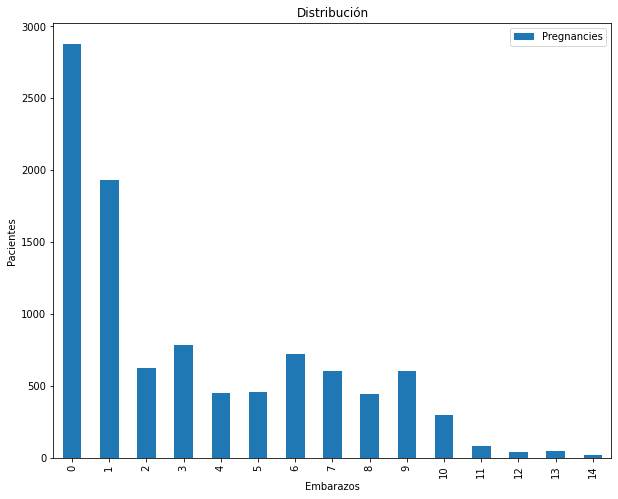

In [14]:
from azureml.core import Experiment
import matplotlib.pyplot as plt
%matplotlib inline
from azureml.widgets import RunDetails


experimento = Experiment(workspace = ws, name = "ml-imagemaker-1")

run = experimento.start_logging()
RunDetails(run).show()

print("Iniciando el experimento:", experimento.name)

df = Dataset.get_by_name(workspace = ws, name='diabetes-azure').to_pandas_dataframe()

row_count = (len(df))
run.log('observaciones totales:', row_count)

embarazos = df['Pregnancies'].value_counts().reset_index().sort_values(by='index')
embarazos.set_index('index',inplace=True)
print(embarazos.head())
fig = plt.figure(figsize=(10,8))
ax = fig.gca()    
embarazos.plot.bar(ax = ax) 
ax.set_title('Distribución') 
ax.set_xlabel('Embarazos') 
ax.set_ylabel('Pacientes')
plt.show()
run.log_image(name = 'distribución embarazos', plot = fig)

edades = df.Age.unique()
run.log_list('edades dataset', edades)

descripcion = df.describe().reset_index()
import numpy as np
np.array(descripcion)
run.log_table('descripción dataset',{x:list(descripcion[x].values) for x in descripcion.columns})

run.complete()


## Nos acercamos al momento de la verdad
Ya que tenemos nuestros datos correctamente cargados con su versionamiento respectivo, entendimos como funcionaban los experimentos y los logs, podemos avanzar a hacia la creación de modelos.
## ¡Ambientes!
Docker hace bastante tiempo es una gran alternativa ante la dificultad que implica generar ambientes replicables. Azure nos entrega la capacidad de usarlo, sin tener idea de como armar un Dockerfile. El ambiente se separa por Python y Docker, y cada uno de ellos tiene sus propias adecuaciones (como las dependencias de conda).
## Registrar el ambiente
Al igual que en los casos anteriores, podemos registrar el ambiente en el workspace. Esto nos entrega todos los beneficios de replicabilidad asociados al versionamiento.

In [15]:
from azureml.core import Environment
from azureml.core.conda_dependencies import CondaDependencies

diabetes_env = Environment("diabetes-experiment-env")
diabetes_env.python.user_managed_dependencies = False
diabetes_env.docker.enabled = True

diabetes_packages = CondaDependencies.create(conda_packages=['scikit-learn==0.22.2.post1'],
                                          pip_packages=['azureml-defaults'])

diabetes_env.python.conda_dependencies = diabetes_packages

diabetes_env.environment_variables = {"MESSAGE":"Hello from Azure Machine Learning"}

print(diabetes_env.name, 'defined.')

diabetes_env.register(workspace=ws)

diabetes-experiment-env defined.


{
    "databricks": {
        "eggLibraries": [],
        "jarLibraries": [],
        "mavenLibraries": [],
        "pypiLibraries": [],
        "rcranLibraries": []
    },
    "docker": {
        "arguments": [],
        "baseDockerfile": null,
        "baseImage": "mcr.microsoft.com/azureml/intelmpi2018.3-ubuntu16.04:20200821.v1",
        "baseImageRegistry": {
            "address": null,
            "password": null,
            "registryIdentity": null,
            "username": null
        },
        "enabled": true,
        "platform": {
            "architecture": "amd64",
            "os": "Linux"
        },
        "sharedVolumes": true,
        "shmSize": null
    },
    "environmentVariables": {
        "MESSAGE": "Hello from Azure Machine Learning"
    },
    "inferencingStackVersion": null,
    "name": "diabetes-experiment-env",
    "python": {
        "baseCondaEnvironment": null,
        "condaDependencies": {
            "channels": [
                "anaconda",
       

## Creamos la imagen

In [16]:
from azureml.core import Image
build = diabetes_env.build(workspace=ws)
build.wait_for_completion(show_output=True)

Image Build Status: Running

2020/11/16 16:47:01 Downloading source code...
2020/11/16 16:47:03 Finished downloading source code
2020/11/16 16:47:03 Creating Docker network: acb_default_network, driver: 'bridge'
2020/11/16 16:47:04 Successfully set up Docker network: acb_default_network
2020/11/16 16:47:04 Setting up Docker configuration...
2020/11/16 16:47:05 Successfully set up Docker configuration
2020/11/16 16:47:05 Logging in to registry: 901ce892322a46198be55695416dc019.azurecr.io
2020/11/16 16:47:06 Successfully logged into 901ce892322a46198be55695416dc019.azurecr.io
2020/11/16 16:47:06 Executing step ID: acb_step_0. Timeout(sec): 5400, Working directory: '', Network: 'acb_default_network'
2020/11/16 16:47:06 Scanning for dependencies...
2020/11/16 16:47:07 Successfully scanned dependencies
2020/11/16 16:47:07 Launching container with name: acb_step_0
Sending build context to Docker daemon     64kB


Step 1/15 : FROM mcr.microsoft.com/azureml/intelmpi2018.3-ubuntu16.04:20200821.

## ¡Creamos scripts reutilizables!
Una gran característica que ofrece Azure Machine Learning, es que podemos entregar scripts como uno de los parámetros de ejecución para un Estimator. ¿Qué es un Estimator? Bueno al parecer me estoy adelantando, vamos a crear la carpeta primero

In [17]:
import os

experiment_folder = 'diabetes_training_from_tab_dataset'
os.makedirs(experiment_folder, exist_ok=True)
print(experiment_folder, 'folder created')

diabetes_training_from_tab_dataset folder created


## Definiendo el script donde entrenaremos nuestro modelo
En la siguiente celda, importamos todos los paquetes necesarios y utilizamos argparse para poder incluir parámetros entregados desde afuera a nuestro código. Es importante destacar también que para inicializar el "run" es necesario utilizar get_context(), para contextualizar el experimento que se entregó desde afuera.
## Entrenamiento del modelo
Como vamos a entender más adelante, debemos entregar como input nuestros datos. Además  podemos registrar las métricas que más podrían interesarnos. En este caso evaluaremos el accuracy y el área bajo la curva ROC. El modelo a entrenar será un Random Forest e intentaremos predecir si se diagnóstica o no diabetes. Como último paso debemos guardar el modelo en la carpeta indicada.

In [18]:
%%writefile $experiment_folder/diabetes_training.py

import os
import argparse
from azureml.core import Run
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

parser = argparse.ArgumentParser()
parser.add_argument('--information', type=str, dest='criterion', default='gini', help='entropy or gini')
parser.add_argument('--depth', type=float, dest='max_depth', default=7, help='max depth')
args = parser.parse_args()
criterion = args.criterion
max_depth = args.max_depth

run = Run.get_context()

print("Loading Data...")
diabetes = run.input_datasets['diabetes'].to_pandas_dataframe()

X, y = diabetes[['Pregnancies','PlasmaGlucose','DiastolicBloodPressure','TricepsThickness','SerumInsulin','BMI','DiabetesPedigree','Age']].values, diabetes['Diabetic'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40, stratify = y)


print('Training a Random Forest Regressor', criterion)
run.log('information',  np.array(criterion))
model = RandomForestClassifier(criterion=criterion,max_depth=max_depth).fit(X_train, y_train)


y_hat = model.predict(X_test)
acc = np.average(y_hat == y_test)
print('Accuracy:', acc)
run.log('Accuracy', np.float(acc))

y_scores = model.predict_proba(X_test)
auc = roc_auc_score(y_test,y_scores[:,1])
print('AUC: ' + str(auc))
run.log('AUC', np.float(auc))

os.makedirs('outputs', exist_ok=True)
joblib.dump(value=model, filename='outputs/diabetes_model.pkl')

run.complete()




Overwriting diabetes_training_from_tab_dataset/diabetes_training.py


## Estimadores
Para conseguir una ejecución en nuestro ambiente, debemos específicar otros diferentes requerimientos. Entre ellos los inputs, el script, el compute_target y el ambiente. Todas estas funcionalidades y más se pueden conseguir con los Estimator de Azure Machine Learning. 
## Parámetros
Como vemos en la siguiente celda, tenemos que entregar como parámetros todos los requirimientos de los que hablamos. Por ejemplo para llamar al ambiente, podemos invocarlo por su nombre y nos entregará por default la última versión.
## Seguimiento de la ejecución
Para ir revisando los logs de la ejecución utilizamos RunDetails(), de esta forma sabemos en que parte de la construcción del ambiente estamos, como también podemos ir viendo directamente las métricas que nos interesaba recabar.

In [24]:
from azureml.core.model import Model
from azureml.train.estimator import Estimator

from azureml.core import Experiment
from azureml.widgets import RunDetails

for i in [['gini',13],['entropy',7]]:
    # Set the script parameters
    script_params = {
    '--information': i[0],
    '--depth': i[1]
    }

# Get the training dataset
    diabetes_ds = Dataset.get_by_name(workspace = ws, name='diabetes-azure', version=2)

# Create an estimator
    estimator = Estimator(source_directory=experiment_folder,
                      inputs=[diabetes_ds.as_named_input('diabetes')],
                      entry_script='diabetes_training.py',
                      compute_target='local',
                      environment_definition=Environment.get(workspace=ws,name='diabetes-experiment-env')
                      )

# Create an experiment
    experiment_name = 'diabetes-training-1'
    experiment = Experiment(workspace = ws, name = experiment_name)

# Run the experiment
    run = experiment.submit(config=estimator)
# Show the run details while running
    RunDetails(run).show()
    run.wait_for_completion()

WARNING - If 'script' has been provided here and a script file name has been specified in 'run_config', 'script' provided in ScriptRunConfig initialization will take precedence.


_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

WARNING - If 'script' has been provided here and a script file name has been specified in 'run_config', 'script' provided in ScriptRunConfig initialization will take precedence.


_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

TypeError: register() missing 1 required positional argument: 'workspace'

## Configuración y registro del modelo
Como vemos, necesitamos distintos parámetros para poder registrar el modelo, los parámetros, model_framework y resource_configuration, nos van a permitir hacer el deployment a una ACI.

In [27]:
from azureml.core.resource_configuration import ResourceConfiguration

model_path=Model.get_model_path('diabetes_model',_workspace=ws)
model = Model.register(workspace=ws, model_name='diabetes_model',
                       model_path=model_path,
                   tags={'Training context':'Inline Training'},
                   properties={'AUC': run.get_metrics()['AUC'], 'Accuracy': run.get_metrics()['Accuracy']},
                  model_framework=Model.Framework.SCIKITLEARN,
                  model_framework_version='0.22.2.post1',
                   resource_configuration=ResourceConfiguration(cpu=1, memory_in_gb=0.5))

Registering model diabetes_model


## Script de inferencia
Cuando queremos customizar nuestros despliegues, ya sea para usar nuestros propias imagenes o para poner en producción modelos en AKS, necesitamos configurar scripts de inferencia. Estos scripts son bastante standard y consisten de dos métodos init y run. Basta cargar el modelo correctamente en init y generar la predicción en run.

In [ ]:
%%writefile score.py
import json
import numpy as np
import os

import joblib
def init():
    global model
    model_path = Model.get_model_path('diabetes_model')
    model = joblib.load(model_path)
def run(data):
    try:
        result = model.predict(data)
        return result.tolist()
    except Exception as e:
        error = str(e)
        return error

## Deployment!
Finalmente estamos llegando al despliegue de nuestro modelo. En este caso el deployment será a una ACI, que es el caso propuesto para testeo. AKS o Azure Ml Compute son mejores opciones para producción.

In [30]:
from azureml.core.model import Model
import joblib

from azureml.core.model import InferenceConfig
inference_config = InferenceConfig(entry_script="score.py", 
                                   environment=diabetes_env)


service_name = 'my-diabetes-service-1'
service = Model.deploy(ws, service_name, [model])

service.wait_for_deployment(True)
print(service.state)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running................................................

WARNING - Retrying (Retry(total=2, connect=3, read=2, redirect=None, status=None)) after connection broken by 'ProtocolError('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer'))': /history/v1.0/subscriptions/f8bfdf2d-85b0-4844-baa4-58c04df2eee8/resourceGroups/resource_testing/providers/Microsoft.MachineLearningServices/workspaces/workshop_imagemaker/experimentids/87826156-88cd-4309-9500-0b89191d5cdf/runs/150be877-994b-4a1a-b81a-d68557395f0d


.......................................
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy


## Vamos a aprovechar nuestro modelo entonces
Esta es una de las distintas formas en la que podemos invocar los resultados del modelo. Pero también hay opciones para llamarlo directamente de aplicaciones. Para no salirnos de nuestro Jupyter notebook, les voy a mostrar a continuación la forma para hacerlo desde este ambiente.

In [36]:
import json


input_payload = json.dumps({
    'data': [
        [ 2,  170,  80, 34, 200,
         40, 1.1, 50]
    ],
    'method': 'predict_proba' 
})

output = service.run(input_payload)

print(output)

{'predict_proba': [[0.7410109321776378, 0.2589890678223622]]}


## Probemos solo con predict

In [ ]:
import json


input_payload = json.dumps({
    'data': [
        [ 2,  170,  80, 34, 200,
         40, 1.1, 50]
    ],
    'method': 'predict'  
})

output = service.run(input_payload)

print(output)

## Terminamos!!
Espero que todo lo que aprendimos te haya sido de utilidad. Aprendimos sobre ambientes, datos, modelos y ambientes productivos. Fueron unas dos horas largas, pero te aseguro que te va a resultar útil adquirir esta nueva skill.